In [1]:
import torch
from torch import nn, autograd
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Running on {device}')

Running on cuda


In [3]:
bs = 10             # batch size
d_ratio = 20        # number of discriminator steps for every generator step
lambda_gp = 10      # gradient penalty for WGAN-GP

In [4]:
mnist_data = torchvision.datasets.MNIST('MNIST',download=True,transform=ToTensor())

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 6560362.15it/s]


Extracting MNIST\MNIST\raw\train-images-idx3-ubyte.gz to MNIST\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28800688.02it/s]


Extracting MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 7520158.71it/s]


Extracting MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4549923.28it/s]

Extracting MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\MNIST\raw



In [5]:
target_dataloader = DataLoader(mnist_data, batch_size=bs, shuffle=True)

In [6]:
#Random Noise
def get_noise(n=None):
    if not n:
    n = bs
    return torch.rand(n,8,4,4).to(device)

In [7]:
class Upsample_block(nn.Module):
"""
  Increases the size of the "image" by a factor of 2
"""
  def __init__(self,chan_in,chan_out):
    super().__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(chan_in,chan_out,3,stride=2,padding=1,output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chan_out),
        nn.Conv2d(chan_out,chan_out,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chan_out),
        nn.Conv2d(chan_out,chan_out,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chan_out)
    )
    def forward(self,X):
        return self.model(X)

In [8]:
class Generator(nn.Module):
    def __init__(self, upsample_block):
        super().__init__()
        self.model = nn.Sequential(
          upsample_block(8,64), # 4 --> 8
          upsample_block(64,32), # 8 --> 16
        )
        self.final_block = nn.Sequential(
          nn.ConvTranspose2d(32,8,3,stride=2,padding=3,output_padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(8),
          nn.Conv2d(8,1,3,padding=1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self,Z):
        out = self.model(Z)
        out = self.final_block(out)
        out = self.sigmoid(out)
        return out

In [9]:
class Downsample_block(nn.Module):
    """
    Decreases the size of the "image" by a factor of 2
    """
    def __init__(self, chan_in, chan_out):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(chan_in, chan_out,3,stride=2,padding=1),
            nn.LeakyReLU()
        )
    def forward(self,X):

        return self.model(X)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, downsample_block):
    super().__init__()
    self.model = nn.Sequential(
      downsample_block(1,16), # 28 --> 14
      downsample_block(16,32), # 14 --> 7
      downsample_block(32,16), # 7 --> 4
      downsample_block(16,8), # 4 --> 2
      downsample_block(8,1), # 2 --> 1
      nn.Sigmoid()
    )

    def forward(self,X):
    out = self.model(X)
    return out.squeeze()

In [11]:
def compute_gp(D, real_data, fake_data):
"""
  Computes the Gradient Penalty for the WGAN
"""
    eps = torch.rand(bs, 1, 1, 1).to(device)
    eps = eps.expand_as(real_data)
    interpolation = eps * real_data + (1 - eps) * fake_data
    interp_logits = D(interpolation)
    grad_outputs = torch.ones_like(interp_logits)
    gradients = autograd.grad(
      outputs=interp_logits,
      inputs=interpolation,
      grad_outputs=grad_outputs,
      create_graph=True,
      retain_graph=True,
    )[0]
    gradients = gradients.view(bs, -1)
    grad_norm = gradients.norm(2, 1)
    return torch.mean((grad_norm - 1) ** 2)

In [12]:
G = Generator(Upsample_block).to(device)
D = Discriminator(Downsample_block).to(device)

In [13]:
G_optimiser = torch.optim.Adam(G.parameters())
D_optimiser = torch.optim.Adam(D.parameters())

In [14]:
def train_generator(G,D,G_optimiser):
    Z = get_noise()
    loss = -torch.mean(D(G(Z)))
    G_optimiser.zero_grad()
    loss.backward()
    G_optimiser.step()

In [15]:
def train_discriminator(X,G,D,D_optimiser):
      """
      Implementation of WGAN
      """
    X = X.to(device)
    Z = get_noise()
    fakes = G(Z)
    gp = compute_gp(D, X, fakes)
    loss = -torch.mean(D(X)) + torch.mean(D(fakes)) + lambda_gp * gp
    D_optimiser.zero_grad()
    loss.backward()
    D_optimiser.step()

In [16]:
EPOCHS = 20

progress_images = []
for epoch in tqdm(range(EPOCHS)):
    for i in range(len(target_dataloader)):
        X,_ = next(iter(target_dataloader))
        train_discriminator(X,G,D,D_optimiser)
        if i % d_ratio == 0:
            train_generator(G,D,G_optimiser)
            
    Z = get_noise(n=1)
    progress_images.append(G(Z).cpu())

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [43:31<00:00, 130.56s/it]


In [17]:
def show_progression(images):
    n = len(images)
    fig = plt.figure(figsize=(9,9*n))
    rows,cols = 1,n
    for i in range(1,rows*cols+1):
        img = images[i-1].squeeze().detach().numpy()
        fig.add_subplot(rows,cols,i)
        plt.imshow(img,cmap="gray")
        plt.axis("off")
        plt.show()

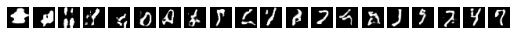

In [18]:
show_progression(progress_images)

In [19]:
def generate_fakes(number):
    Z = get_noise(n=number)
    fakes = G(Z).cpu()
    return fakes

In [26]:
def generate_reals(number):
    reals = []
    for i in range(number):
        idx = torch.randint(len(mnist_data),(1,)).item()
        img = mnist_data[i][0]
        reals.append(img)
        return reals

In [22]:
def show_sample(images,size):
    fig = plt.figure(figsize=(9,9))
    rows,cols = size
    for i in range(1,rows*cols+1):
    idx = torch.randint(len(images),(1,)).item()
    img = images[idx].squeeze().detach().numpy()
    fig.add_subplot(rows,cols,i)
    plt.imshow(img,cmap="gray")
    plt.axis("off")
    plt.show()

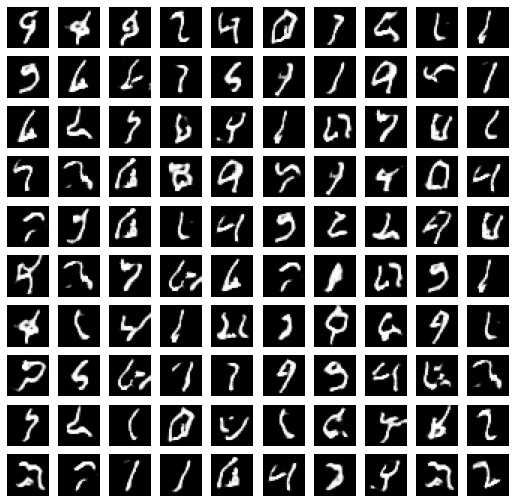

In [23]:
fakes = generate_fakes(100)
show_sample(fakes,(10,10))

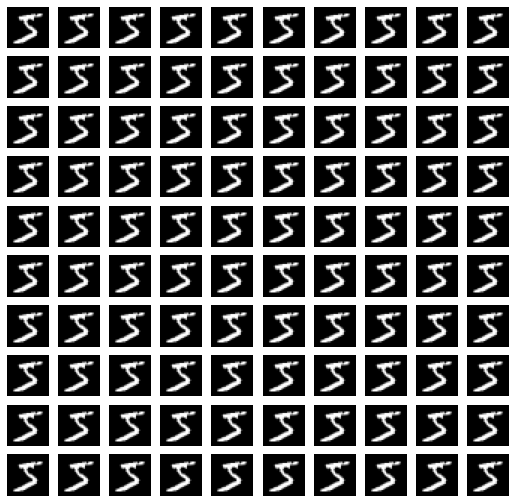

In [85]:
show_sample(generate_reals(100),(10,10))

In [76]:
def save_real_sample(data):
    os.chdir(r"C:\Users\root\Documents\Pytorch\MNIST_GAN\Real_Sample")
    for i in tqdm(range(100)):
        idx = torch.randint(len(data),(1,)).item()
        img = data[i][0]
        img_name = f'real-image-{i+1}.png'
        save_image(img,img_name)

In [80]:

def save_fake_sample(images):
    os.chdir(r"C:\Users\root\Documents\Pytorch\MNIST_GAN\Fake_Sample")
    for i in tqdm(range(len(images))):
        img = images[i].squeeze(0).detach()
        img_name = f'fake-image-{i+1}.png'
        save_image(img,img_name)

In [82]:
if len(os.listdir(r"C:\Users\root\Documents\Pytorch\MNIST_GAN\Real_Sample")) == 0:
    save_real_sample(mnist_data)
    os.chdir(r"C:\Users\root\Documents\Pytorch\MNIST_GAN\Fake_Sample")
if len(os.listdir(r"C:\Users\root\Documents\Pytorch\MNIST_GAN\Real_Sample")) > 0:
    old_fakes = glob.glob(r'C:\Users\root\Documents\Pytorch\MNIST_GAN\Fake_Sample\*')
    for f in old_fakes:
    os.remove(f)
save_fake_sample(fakes)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1401.56it/s]
